In [1234]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression
from sys import stdout

plt.rcParams['figure.figsize'] = (20,10)

In [1235]:
# For extracting HITRAN data

def txt_c(url, mirror=False):
    data = []
    wav = []
    m = 1

    with open(url, 'r') as file:

        for i in file:
            if not '#' in str(i):
                data.append( [float(x) for x in i.replace('\t', ' ').split(' ')] )
                
    if mirror:
        m = -1
    data, wav = np.array([x[1] * m for x in data]), np.array([x[0] for x in data]) 
    data = (data - data.min()) / (data.max() - data.min())
    return data, wav

In [ ]:
# For extracting QUEPAS data

import numpy as np
def extract_dfm(path):
    X = []
    with open(path, 'r') as file:
        for i in file:
            if 'nan' in i:
                pass
            else:
                try:
                    data =  [float(x) for x in i.replace('\t', ' ').split(',')] 
                    X.append(data)
                except Exception as e:
                    pass
    X = (X - X.min()) / (X.max() - X.min())
    return np.array(X)

In [1284]:
# Mixer to simulate training 
# For inference on real data, the hypothesis that combination of gasses are a linear combination that does not produce any
# non-linearities, needs to be confirmed by comparing real combination data to synthetically produced combination of real data

import random
def make_signal(signals, cycles, max_noise=0):
    """
    signals: list/array of the signals to be combined
    All spectras produced by this method is a y = (X1*C1) + .. (Xn*Cn) combination with added noise.
    
    cycles: number of spectras that will be produced such that Lenght of X AND lenght of y = cycles
    
    max_noise: The maximun additive noise. The noise is additive and possitive such that min noise = 0 and 
    max noise = max noise. the added noise will for every x in X be a random number in the interval minNoise-maxNoise
    
    """
    X = []
    coef_list = []
    for i in range(cycles):
        
        coefficients_ = [random.uniform(0,100000) for i in range(len(signals))]
        
        coef_list.append(coefficients_)
        
        comb = np.array([sig * coef for sig, coef in zip(signals, coefficients_)]).sum(axis=0)

        noise = np.array([random.uniform(0, max_noise) for x in range(len(signals[0]))])
        
        noise_comb = np.array((comb + noise))
                
        X.append(noise_comb)
    
    return np.array(X), np.array(coef_list)

In [1325]:
water, waterW = txt_c(r"C:\Users\benja\OneDrive\Skrivebord\DFM data\Gas concentration\202208 metan QEPAS og HITRAN\Hitran 2850 to 3500\hitran H2O 10ppm 5cm-1.txt", True)
amonia, amoniaW = txt_c(r"C:\Users\benja\OneDrive\Skrivebord\DFM data\Gas concentration\202208 metan QEPAS og HITRAN\Hitran 2850 to 3500\hitran CH4 10 ppm 5cm-1.txt", True)

wl = waterW

In [1381]:
X, y = make_signal(np.array([water, amonia]), 40, 0.05)

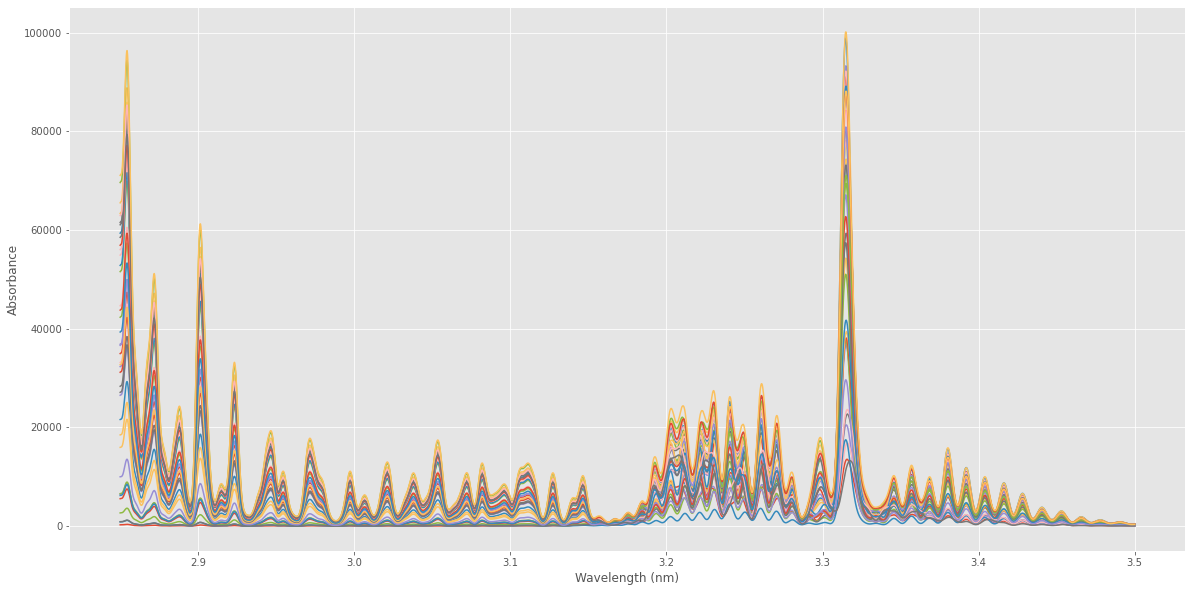

In [1382]:
# Plot spectra to see variance and noise lvl

with plt.style.context(('ggplot')):
    plt.plot(wl, X.T)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absorbance')
plt.show()

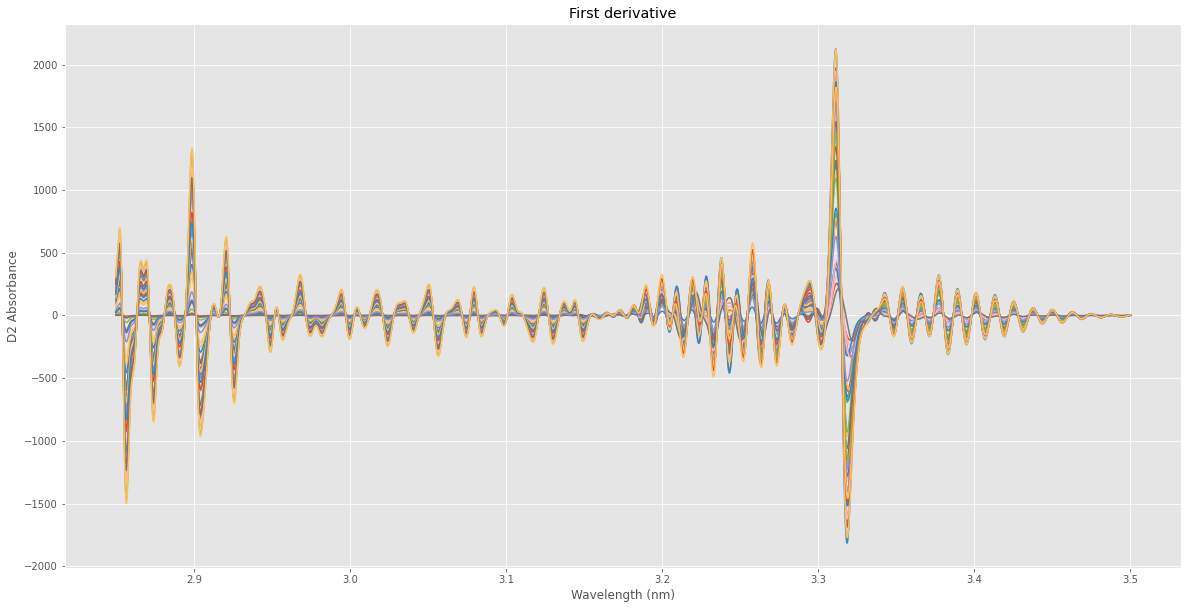

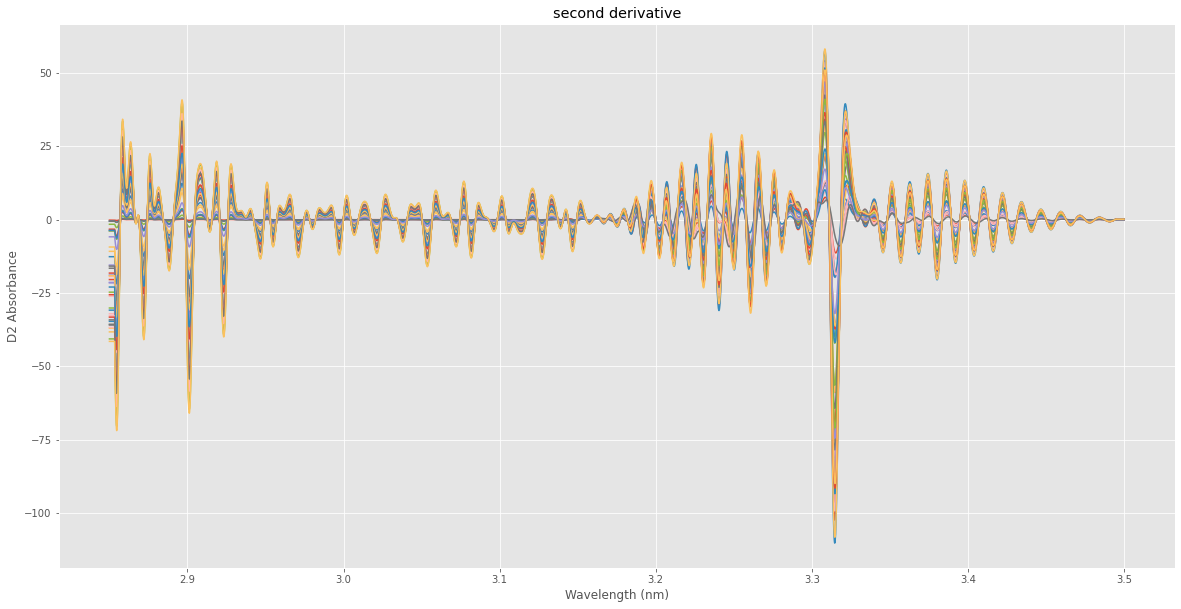

In [1383]:

# Calculate sfirst and second derivative
# This should be automated in some way..


X1 = savgol_filter(X, 37, polyorder=2, deriv=1) # Filter size for savgol should be selected according to noise lvl
X2 = savgol_filter(X, 57, polyorder = 2, deriv=2) # More noise = bigger filter

# Plot first derivative
plt.figure()
with plt.style.context(('ggplot')):
    plt.plot(wl, X1.T)
    plt.title('First derivative')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Absorbance')
    plt.show()

# Plot second derivative
plt.figure()
with plt.style.context(('ggplot')):
    plt.plot(wl, X2.T)
    plt.title('second derivative')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('D2 Absorbance')
    plt.show()

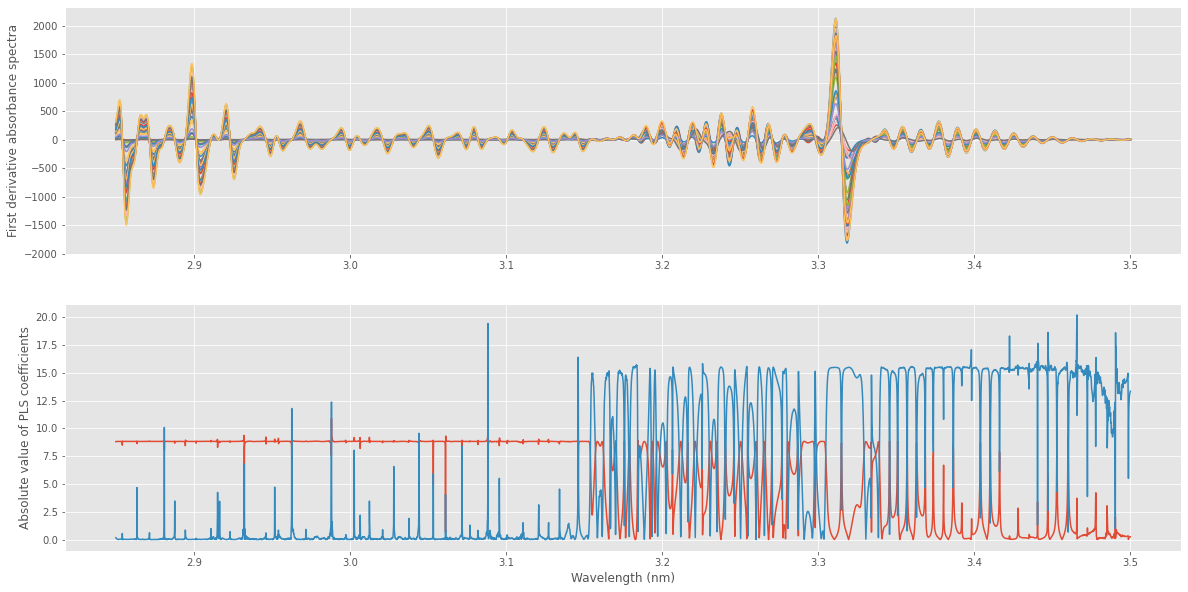

In [1384]:
# Arbitraty 8 pc choosen..
pls = PLSRegression(n_components=8)

pls.fit(X1, y)
 
# Plot spectra
plt.figure()
with plt.style.context(('ggplot')):
    ax1 = plt.subplot(211)
    plt.plot(wl, X1.T)
    plt.ylabel('First derivative absorbance spectra')
 
    ax2 = plt.subplot(212, sharex=ax1)
    plt.plot(wl, np.abs(pls.coef_))
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Absolute value of PLS coefficients')
 
    plt.show()

In [1385]:
def optimise_pls_cv(X, y, n_comp, plot_components=True):
 
    '''Run PLS including a variable number of components, up to n_comp,
       and calculate MSE '''
    
    """
    Returns the trained/fitted PLS object that can/should be used for inference
    
    """
 
    mse = []
    component = np.arange(1, n_comp)
 
    for i in component:
        pls = PLSRegression(n_components=i)
 
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=2)
 
        mse.append(mean_squared_error(y, y_cv))
 
        comp = 100*(i+1)/(n_comp)
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # Calculate and print the position of minimum in MSE
    msemin = np.argmin(mse)
    print("Suggested number of components: ", msemin+1)
    stdout.write("\n")
 
    if plot_components is True:
        with plt.style.context(('ggplot')):
            plt.plot(component, np.array(mse), '-v', color = 'blue', mfc='blue')
            plt.plot(component[msemin], np.array(mse)[msemin], 'P', ms=10, mfc='red')
            plt.xlabel('Number of PLS components')
            plt.ylabel('MSE')
            plt.title('PLS')
            plt.xlim(left=-1)
 
        plt.show()
 
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=msemin+1)
 
    # Fir to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
 
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=2)
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
 
    
    try:
        rangey = [y[:,i] for i in range(len(y[0]))]
        rangey_c = [y_c[:,i] for i in range(len(y_c[0]))]
    except Exception as e:
        rangey = [y]
        rangey_c = [y_c]
        
    # Fit a line to the CV vs response
    for i, ys in enumerate(zip(rangey, rangey_c)):
        z = np.polyfit(ys[0], ys[1], 1)
        with plt.style.context(('ggplot')):
            fig, ax = plt.subplots(figsize=(9, 5))
            ax.scatter(ys[1], ys[0], c='red', edgecolors='k')
            
            #Plot the best fit line
            ax.plot(np.polyval(z,ys[0]), ys[0], c='blue', linewidth=1)
            #Plot the ideal 1:1 line
            ax.plot(ys[0], ys[0], color='green', linewidth=1)
            
            plt.title('Fit on {} component coefficients'.format(i))
            plt.xlabel('Predicted ratio')
            plt.ylabel('Actual ratio')

            plt.show()
 
    return pls_opt, y_c

100% completed
Suggested number of components:  24



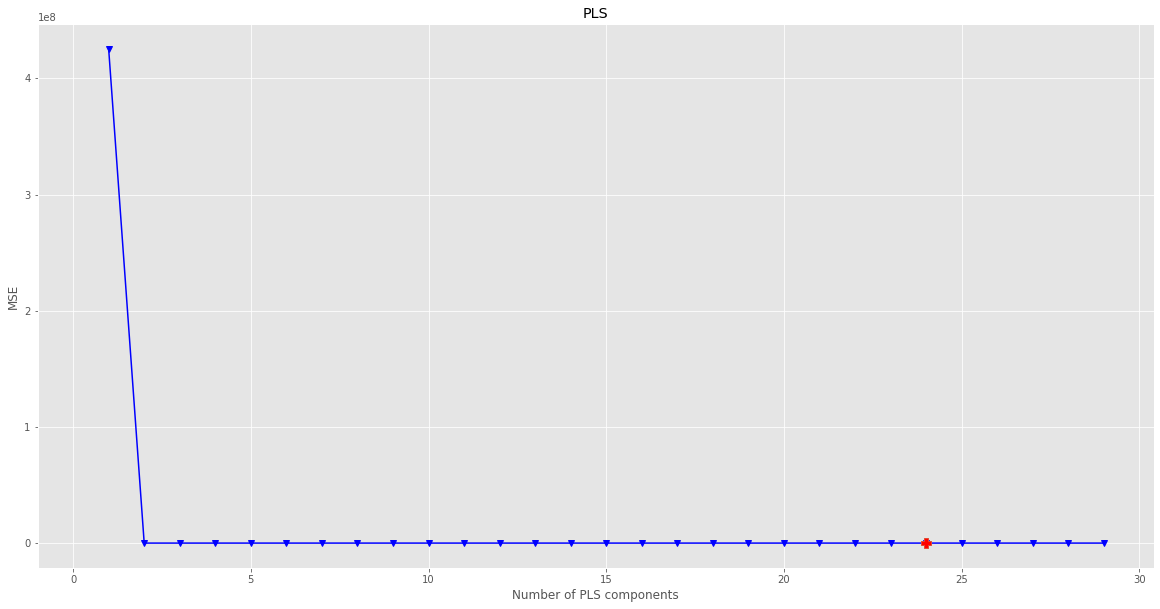

R2 calib: 1.000
R2 CV: 1.000
MSE calib: 0.000
MSE CV: 0.000


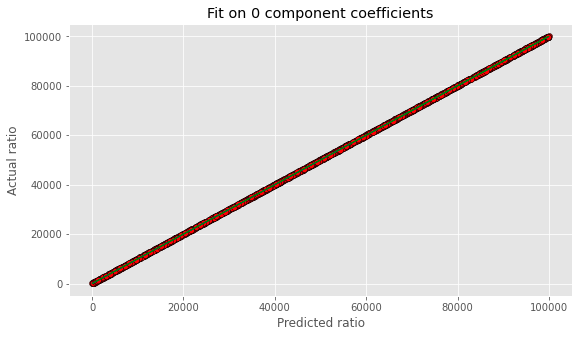

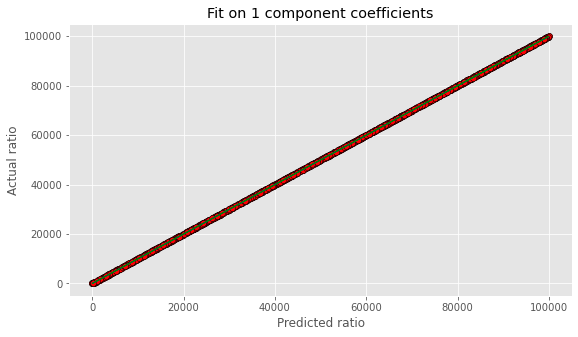

In [1292]:
# X Can be swapped for a derivative of X, if there is a lot of noise in #
pls_opt, predictions = optimise_pls_cv(X,y, 30, plot_components=True) 

In [1412]:
# To test the optimized pls I Created this toy data which has a simulated 1part amonia - 100000 parts water ratio.
# This ratio is not based on the actual intensety of the subjects, 
# as it disregards the actual siganal intensety of the measured subject and 
# the real (Non normalised) subjects should be used instead.
# The reason i did not do this, is because I think the data I was given (hitran) is faulty, 
# as the numerical values and scales did not make sense to me. (Water very weak everything else extremely strong)

# I use the same additive noise weights as for training, to simulate a constant measurement time and hardware setup
# This setup is a lazy test for composite of two subjects and should be extended for use in n subjects
def test_of_range():
    X_ = np.array([water, amonia])

    coefs_ = np.array([[100, 1], [1000, 1], [10000, 1], [100000, 1]])

    X__ =  np.array([np.sum([X_[0] * co[0] + X_[1] * co[1]], axis=0) + random.uniform(0, 0.05) for co in coefs_])
    return X__, coefs_


In [ ]:
X__, coefs_ = test_of_range()
y_c = pls_opt.predict(X__)
score_c = r2_score(coefs_, y_c)

print(score_c)
print(y_c[0:5], coefs_[0:5])
print(coefs_ - y_c)

In [1386]:
# To check which wavelength bands lead to a better quality model.
# we check which bands give a worse quality model, so we can get rid of them.

# This routine both selects the optimal number of PC and selects which wavebands that holds the information
# This method is VERY slow as it is itterative on the size of the dataset X.. So arm yourself with a lot of patience

def pls_variable_selection(X, y, max_comp):
    
    # Define MSE array to be populated
    mse = np.zeros((max_comp,X.shape[1]))
 
    # Loop over the number of PLS components
    for i in range(max_comp):
        
        # Regression with specified number of components, using full spectrum
        pls1 = PLSRegression(n_components=i+1)
        pls1.fit(X, y)
        
        # Indices of sort spectra according to ascending absolute value of PLS coefficients
        sorted_ind = np.argsort(np.abs(pls1.coef_).sum(axis=1))
 
        # Sort spectra accordingly 
        Xc = X[:,sorted_ind]
 
        # Discard one wavelength at a time of the sorted spectra,
        # regress, and calculate the MSE cross-validation
        for j in range(Xc.shape[1]-(i+1)):
 
            pls2 = PLSRegression(n_components=i+1)
            pls2.fit(Xc[:, j:], y)
            
            y_cv = cross_val_predict(pls2, Xc[:, j:], y, cv=5)
 
            mse[i,j] = mean_squared_error(y, y_cv)
    
        comp = 100*(i+1)/(max_comp)
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
 
    # # Calculate and print the position of minimum in MSE
    mseminx,mseminy = np.where(mse==np.min(mse[np.nonzero(mse)]))
 
    print("Optimised number of PLS components: ", mseminx[0]+1)
    print("Wavelengths to be discarded ",mseminy[0])
    print('Optimised MSEP ', mse[mseminx,mseminy][0])
    stdout.write("\n")
    # plt.imshow(mse, interpolation=None)
    # plt.show()
 
 
    # Calculate PLS with optimal components and export values
    pls = PLSRegression(n_components=mseminx[0]+1)
    pls.fit(X, y)
        
    sorted_ind = np.argsort(np.abs(pls.coef_).sum(axis=1))
 
    Xc = X[:,sorted_ind]
 
    return(Xc[:,mseminy[0]:],mseminx[0]+1,mseminy[0], sorted_ind)

def simple_pls_cv(X, y, n_comp):
 
    # Run PLS with suggested number of components
    pls = PLSRegression(n_components=n_comp)
    pls.fit(X, y)
    y_c = pls.predict(X)
 
    # Cross-validation
    y_cv = cross_val_predict(pls, X, y, cv=10)    
 
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
 
    # Calculate mean square error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
 
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
 
    # Plot regression 
 
   
    try:
        rangey = [y[:,i] for i in range(len(y[0]))]
        rangey_c = [y_c[:,i] for i in range(len(y_c[0]))]
    except Exception as e:
        rangey = [y]
        rangey_c = [y_c]
        
    # Fit a line to the CV vs response
    for i, ys in enumerate(zip(rangey, rangey_c)):
        z = np.polyfit(ys[0], ys[1], 1)
        with plt.style.context(('ggplot')):
            fig, ax = plt.subplots(figsize=(9, 5))
            ax.scatter(ys[1], ys[0], c='red', edgecolors='k')
            
            #Plot the best fit line
            ax.plot(np.polyval(z,ys[0]), ys[0], c='blue', linewidth=1)
            #Plot the ideal 1:1 line
            ax.plot(ys[0], ys[0], color='green', linewidth=1)
            
            plt.title('Fit on {} component coefficients'.format(i))
            plt.xlabel('Predicted ratio')
            plt.ylabel('Actual ratio')

            plt.show()
 
    return pls_opt, y_c

100% completed
Optimised number of PLS components:  10
Wavelengths to be discarded  114
Optimised MSEP  0.0016348591267163072

R2 calib: 1.000
R2 CV: 1.000
MSE calib: 0.000
MSE CV: 0.002


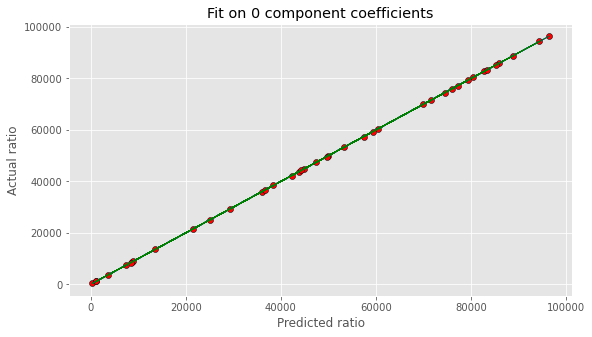

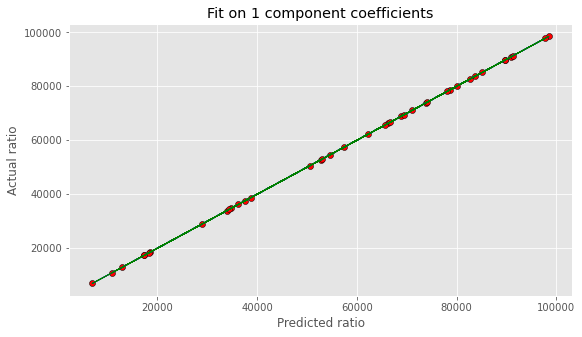

In [1387]:
# or 
opt_Xc, ncomp, wav, sorted_ind = pls_variable_selection(X1, y, 10)
pls, y_c2 = simple_pls_cv(opt_Xc, y, ncomp)

100% completed
Suggested number of components:  20



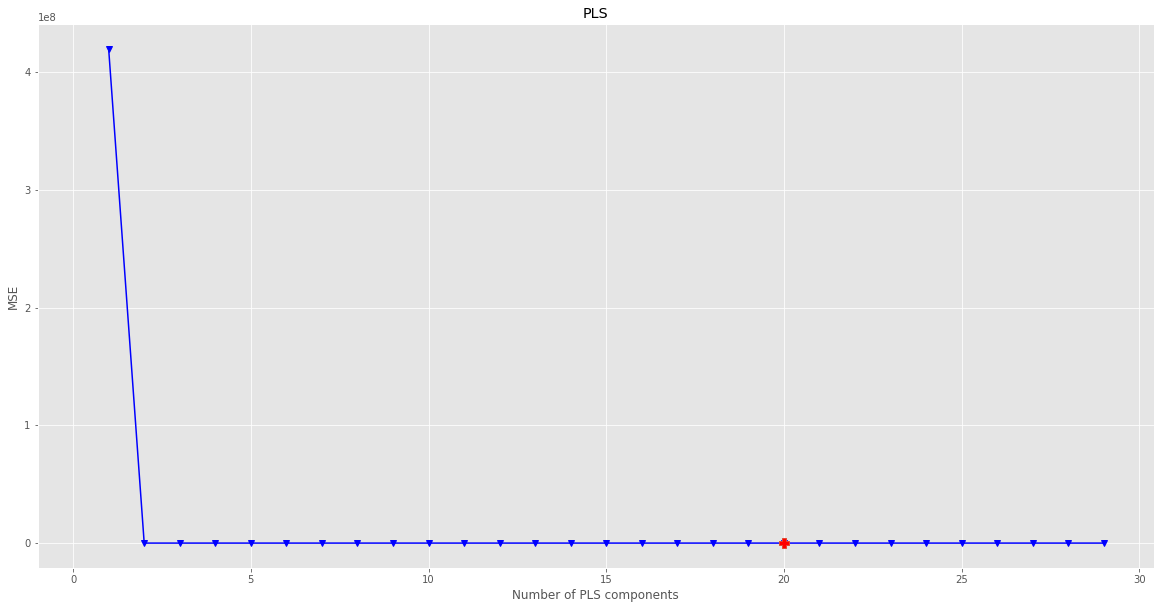

R2 calib: 1.000
R2 CV: 1.000
MSE calib: 0.000
MSE CV: 0.000


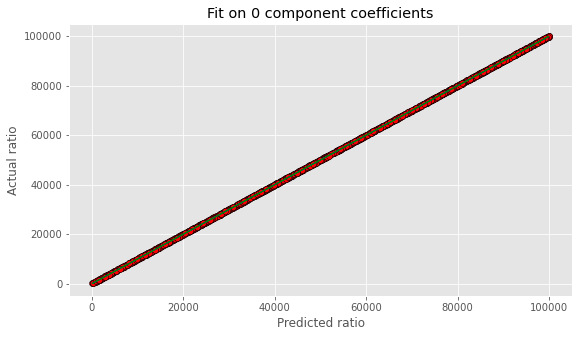

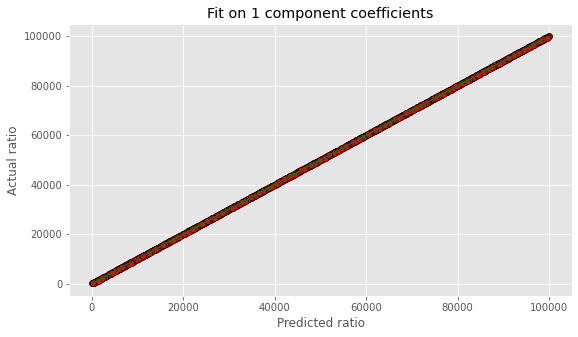

0.49999999999200134
[[9.98968601e+01 8.92132151e-01]
 [1.00030694e+03 1.32140196e+00]
 [9.99994714e+03 9.44633708e-01]
 [9.99999323e+04 9.27934906e-01]] [[   100      1]
 [  1000      1]
 [ 10000      1]
 [100000      1]]
[[ 0.10313992  0.10786785]
 [-0.30694137 -0.32140196]
 [ 0.05286097  0.05536629]
 [ 0.06767087  0.07206509]]


In [1414]:
# Here i remove the wavelength that dont carry so much information on the analytes of interest
# And then train a new PLSR model with a bigger dataset and let it pick a new optimal number of PC
# The results are very good on the synthetic data and if there is no non-linearities in the lab data
# I suspect results will be good on that too
# For a good result with data without non-linearities synthetic data can be created from lab data to train the model instead
# Here the baseline(background) of the test setup should also be used as noise, and 
# I think the data augmentation scheme i created for the ST would do just fine if it is altered to fit this problem

X, y = make_signal(np.array([water, amonia]), 2000, 0.05)

Xc = X[:,sorted_ind]
Xc_ = Xc[:,wav:]

pls_opt, predictions = optimise_pls_cv(Xc_, y, 30, plot_components=True) 

X__, coefs_ = test_of_range()

Xc_test = X__[:,sorted_ind]
Xc_test_ = Xc_test[:,wav:]

y_c = pls_opt.predict(Xc_test_)
score_c = r2_score(coefs_, y_c)

print(score_c)
print(y_c[0:5], coefs_[0:5])
print((coefs_ - y_c)/coefs_)
print((coefs_ - y_c)/coefs_)